# Master DSLS / Programming 3 / Assignment 6
# Final Assignment

## Introduction
https://bioinf.nl/~martijn/master/programming3/assignment6.html

This is the final for programming 3. In this assignment, I will develop scikit-learn machine learning models to predict the function of the proteins in the specific dataset. This model will use small InterPro_annotations_accession to predict large InterPro_annotations_accession.
The definition of small InterPro_annotations_accession and large InterPro_annotations_accession is defined as below:

If InterPro_annotations_accession's feature length(Stop_location-Start_location) / Sequence_length > 0.9, it is large InterPro_annotations_accession.

Otherwise, it is a small InterPro_annotations_accession.

We can briefly rewrite as:

            |(Stop - Start)|/Sequence >  0.9 --> Large

            |(Stop - Start)|/Sequence <= 0.9 --> small

I will also check the "bias" and "noise" that does not make sense from the dataset.

ie. lines(-) from the TSV file which don't contain InterPRO numbers

ie. proteins which don't have a large feature (according to the criteria above)

## 1. Goal

The goal of this assignment is to predict large InterPro_annotations_accession by small InterPro_annotations_accession.

I will use the dataset from /data/dataprocessing/interproscan/all_bacilli.tsv file on assemblix2012 and assemblix2019. However, this file contains ~4,200,000 protein annotations, so I will put a subset of all_bacilli.tsv on GitHub and on local for code testing.

In [186]:
# Spark web UI:http://localhost:4040/jobs/
# Output format : https://interproscan-docs.readthedocs.io/en/latest/OutputFormats.html
import pyspark
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
import numpy as np
import warnings
import time
warnings.filterwarnings('ignore')
import pickle
from pyspark.ml.feature import StringIndexer,VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
import pandas as pd
import matplotlib.pyplot as plt


In [187]:
path= "/homes/dlsteur/Git_repos/Programming3/Assignment6/all_bacilli.tsv"
df = SQLContext(sc).read.csv(path, sep=r'\t', header=None)#.select('col1','col2')
df=df.withColumnRenamed("_c1","Protein")\
   .withColumnRenamed("_c2","Sequence_MD5_digest")\
    .withColumnRenamed("_c3","Sequence_length")\
    .withColumnRenamed("_c4","Analysis")\
    .withColumnRenamed("_c5","Signature_accession")\
    .withColumnRenamed("_c6","Signature_description")\
    .withColumnRenamed("_c7","Start")\
    .withColumnRenamed("_c8","Stop")\
    .withColumnRenamed("_c9","Score")\
    .withColumnRenamed("_c10","Status")\
    .withColumnRenamed("_c11","Date")\
    .withColumnRenamed("_c12","Interpro_accession")\
    .withColumnRenamed("_c13","Interpro_description")\
    .withColumnRenamed("_c14","GO")\
    .withColumnRenamed("_c15","Pathway")
columns=df.columns   
df.limit(10).toPandas()
# remove column "_c0"
df=df.drop("_c0")

# remove InterPro_annotations_accession == "-"
# get the length of protein
df=df.withColumn("feature_Length", ((df['Stop']-df['Start'])))
# get the ratio to distinguish them to large and small InterPro_annotations_accession
df=df.withColumn("ratio", ((df['Stop']-df['Start'])/df['Sequence_length']))
# 1 for large, 0 for small InterPro_annotations_accession        
df=df.withColumn("Size", when((abs(df["Stop"] - df["Start"])/df["Sequence_length"])>0.9,1).otherwise(0))

to_drop=['Sequence_MD5_digest', 'Analysis',
       'Signature_accession', 'Signature_description', 
       'Score', 'Status', 'Date', 'Interpro_description',
       'GO', 'Pathway']
df=df.drop(*to_drop)
# sort on ration from big to small
df=df.sort(df.ratio.desc())
df.toPandas()

,Protein,Sequence_length,Start,Stop,Interpro_accession,feature_Length,ratio,Size
0,gi|29897042|gb|AAP10319.1|,565,1,565,-,564.0,0.998230,1
1,gi|29897042|gb|AAP10319.1|,565,1,565,-,564.0,0.998230,1
2,gi|29894943|gb|AAP08231.1|,444,1,444,-,443.0,0.997748,1
3,gi|29894943|gb|AAP08231.1|,444,1,444,-,443.0,0.997748,1
4,gi|29896607|gb|AAP09886.1|,429,1,429,IPR006264,428.0,0.997669,1
...,...,...,...,...,...,...,...,...
1997,gi|29897329|gb|AAP10605.1|,336,1,1,-,0.0,0.000000,0
1998,gi|29897323|gb|AAP10599.1|,179,1,1,-,0.0,0.000000,0
1999,gi|29896654|gb|AAP09933.1|,547,1,1,-,0.0,0.000000,0
2000,gi|29898742|gb|AAP12014.1|,116,1,1,-,0.0,0.000000,0


In [188]:
# get the intersection to make sure there is a match of large and small InterPro_annotations_accession(at least one large and one small InterPro_annotations_accession)
intersection = df.filter(df.Size == 0).select("Protein").intersect(df.filter(df.Size == 1).select("Protein"))
intersection_df = intersection.join(df,["Protein"])
# intersection_df.toPandas()

# select small proteins in df
small_proteins = df.filter(df.ratio < 0.9)

# select latrge proteins in df
large_proteins = df.filter(df.ratio >= 0.9)

In [189]:
# Check the data
# plot the small InterPro_annotations_accession in each Protein_accession
# create protein_sum column

# df = small_proteins.groupBy("Protein").count().toPandas()
# df.plot(x="Protein", y="count", kind="bar", figsize=(20,3))
# plt.show()
# MLdf = ML_df.toPandas()
# MLdf["protein_sum"] = MLdf.iloc[:,17:].sum(axis=1)
# MLdf


AttributeError: 'DataFrame' object has no attribute 'iloc'

In [ ]:
plt.plot(np.arange(len(df)),df.protein_sum)
plt.title("Protein sequence & small interpro")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency of small InterPro accession")
plt.savefig("Protein sequence & small interpro.png")

TypeError: object of type 'DataFrame' has no len()

(array([801., 194., 226., 182., 139., 110.,  57.,  72.,  70.,  50.,  39.,
         22.,  13.,   8.,   9.,   4.,   1.,   2.,   1.,   2.]),
 array([  0.  ,  41.35,  82.7 , 124.05, 165.4 , 206.75, 248.1 , 289.45,
        330.8 , 372.15, 413.5 , 454.85, 496.2 , 537.55, 578.9 , 620.25,
        661.6 , 702.95, 744.3 , 785.65, 827.  ]),
 <BarContainer object of 20 artists>)

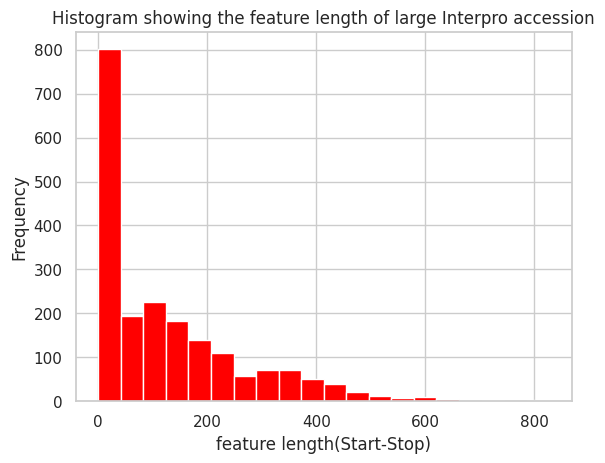

In [ ]:
fig, ax = plt.subplots()
plt.title('Histogram showing the feature length of large Interpro accession')
plt.xlabel('feature length(Start-Stop)')
plt.ylabel('Frequency')
hist(ax,df.select('feature_Length'),bins=20, color=['red'])
#axs[0,1].hist(axs[0,1], large_df.select('feat_len'),bins=20, color=['red'])

In [ ]:
sns.set_theme(style="whitegrid")
ck=small_df.toPandas()
sns.boxplot(x=ck["feature_Length"])
plt.title('Boxplot of small Interpro accessions')
plt.ylabel('Frequency')
plt.show()

KeyError: 'feature_Length'

In [ ]:
# Drop the useless columns
columns = ("Sequence_MD5_digest","Analysis","Signature_accession","Signature_description",
        "Score","Status","Date","InterPro_annotations_description","GO_annotations","Protein",
        "Pathways_annotations","Ratio","Size","Stop","Start","Sequence_length")
ML_df = ML_df.drop(*columns)

In [ ]:
# catalogize y variable
Label = StringIndexer(inputCol="InterPro_annotations_accession", outputCol="InterPro_index")

# catalogize X variable
input_columns = ML_df.columns[1:]
assembler = VectorAssembler(inputCols=input_columns,outputCol="InterPro_features")

pipeline = Pipeline(stages=[Label,assembler])
ML_final = pipeline.fit(ML_df).transform(ML_df)

# Setup X, y and split it
(trainData, testData) = ML_final.randomSplit([0.7, 0.3],seed=42)

Py4JJavaError: An error occurred while calling o2294.fit.
: org.apache.spark.SparkException: Input column InterPro_annotations_accession does not exist.
	at org.apache.spark.ml.feature.StringIndexerBase.$anonfun$validateAndTransformSchema$2(StringIndexer.scala:128)
	at scala.collection.TraversableLike.$anonfun$flatMap$1(TraversableLike.scala:293)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at scala.collection.TraversableLike.flatMap(TraversableLike.scala:293)
	at scala.collection.TraversableLike.flatMap$(TraversableLike.scala:290)
	at scala.collection.mutable.ArrayOps$ofRef.flatMap(ArrayOps.scala:198)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema(StringIndexer.scala:123)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema$(StringIndexer.scala:115)
	at org.apache.spark.ml.feature.StringIndexer.validateAndTransformSchema(StringIndexer.scala:145)
	at org.apache.spark.ml.feature.StringIndexer.transformSchema(StringIndexer.scala:252)
	at org.apache.spark.ml.PipelineStage.transformSchema(Pipeline.scala:71)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:237)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [ ]:
# RandomForestClassifier
# create a model
rf = RandomForestClassifier(labelCol="InterPro_index",
                            featuresCol="InterPro_features",
                            predictionCol="prediction", 
                            seed=42,maxDepth=20,
                            maxMemoryInMB = 256,
                            numTrees=500)
rf_Model = rf.fit(trainData)
predict = rf_Model.transform(testData)

# evaluate the result
evaluator = MulticlassClassificationEvaluator(labelCol='InterPro_index',
                                            predictionCol = 'prediction',
                                            metricName='accuracy')

accuracy = evaluator.evaluate(predict)
print(f"Accuracy is {accuracy}")
# 0.3044988743110007

23/09/11 14:27:51 ERROR Instrumentation: java.lang.IllegalArgumentException: requirement failed
	at scala.Predef$.require(Predef.scala:268)
	at org.apache.spark.ml.util.DatasetUtils$.checkClassificationLabels(DatasetUtils.scala:61)
	at org.apache.spark.ml.classification.RandomForestClassifier.$anonfun$train$1(RandomForestClassifier.scala:153)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:139)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:47)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:78)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.r

IllegalArgumentException: requirement failed

In [ ]:
# Hyperparameter tuning RandomForestClassifier
# create a model
rf = RandomForestClassifier(labelCol="InterPro_index",
                            featuresCol="InterPro_features",
                            predictionCol="prediction", 
                            seed=42,
                            maxMemoryInMB = 256)

# Tuning
paramGrid = (ParamGridBuilder()
            .addGrid(rf.maxDepth, [5,10,20])
            .addGrid(rf.numTrees, [20,100])
            .build())

# evaluate the result
rf_evaluator = MulticlassClassificationEvaluator(labelCol='InterPro_index',
                                            predictionCol = 'prediction',
                                            metricName='accuracy')

# KFold
cv = CrossValidator(estimator=rf,
                    evaluator=rf_evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=5,
                    parallelism=10,
                    seed=42)

# Run Cross-validation
rf_cvModel = cv.fit(trainData)

# Make predictions on testData. cvModel uses the bestModel.
rf_cvPredictions = rf_cvModel.transform(testData)

# Evaluate bestModel found from Cross Validation
rf_evaluator.evaluate(rf_cvPredictions)
# 0.30174287710581477

In [ ]:
# Decision trees
dtc = DecisionTreeClassifier(labelCol="InterPro_index",
                            featuresCol="InterPro_features",
                            predictionCol="prediction")
dtc = dtc.fit(trainData)
dtc_pred = dtc.transform(testData)
dtc_evaluator=MulticlassClassificationEvaluator(labelCol='InterPro_index',
                                                predictionCol = 'prediction',
                                                metricName='accuracy')
dtc_acc = dtc_evaluator.evaluate(dtc_pred)
print("Prediction Accuracy: ", dtc_acc)
# 0.09174365344305567

In [ ]:
# Hyperparameter tuning DecisionTree
# Tuning
dtc = DecisionTreeClassifier(labelCol="InterPro_index",
                            featuresCol="InterPro_features",
                            predictionCol="prediction")  

paramGrid = (ParamGridBuilder()
            .addGrid(dtc.maxDepth, [2,4,6,8,10,12])
            .build())

# evaluate the result
dtc_evaluator = MulticlassClassificationEvaluator(labelCol='InterPro_index',
                                            predictionCol = 'prediction',
                                            metricName='accuracy')

# KFold
cv = CrossValidator(estimator=dtc,
                    evaluator=dtc_evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=5,
                    parallelism=10,
                    seed=42)

# Run Cross-validation
dtc_cvModel = cv.fit(trainData)

# Make predictions on testData. cvModel uses the bestModel.
dtc_cvPredictions = dtc_cvModel.transform(testData)

# Evaluate bestModel found from Cross Validation
dtc_evaluator.evaluate(dtc_cvPredictions)
# 0.13698470615635433

In [ ]:
# Naive Bayes
nb = NaiveBayes(modelType="multinomial",labelCol="InterPro_index",
                    featuresCol="InterPro_features",
                    predictionCol="prediction",)    
nb = nb.fit(trainData)
nb_pred = nb.transform(testData)
nb_evaluator=MulticlassClassificationEvaluator(labelCol='InterPro_index',
                                                predictionCol = 'prediction',
                                                metricName='accuracy')
nb_acc = nb_evaluator.evaluate(nb_pred)
print("Prediction Accuracy: ", nb_acc)
# 0.7822956292213338

In [ ]:
# Hyperparameter tuning Naive Bayes model
# Tuning
nb = NaiveBayes(modelType="multinomial",labelCol="InterPro_index",
                    featuresCol="InterPro_features",
                    predictionCol="prediction",)    

paramGrid = (ParamGridBuilder()
            .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0])
            .build())

# evaluate the result
nb_evaluator = MulticlassClassificationEvaluator(labelCol='InterPro_index',
                                            predictionCol = 'prediction',
                                            metricName='accuracy')

# KFold
cv = CrossValidator(estimator=nb,
                    evaluator=nb_evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=5,
                    parallelism=10,
                    seed=42)

# Run Cross-validation
nb_cvModel = cv.fit(trainData)

# Make predictions on testData. cvModel uses the bestModel.
nb_cvPredictions = nb_cvModel.transform(testData)

# Evaluate bestModel found from Cross Validation
nb_evaluator.evaluate(nb_cvPredictions)
# 0.8476049996118313

In [ ]:
# save file
trainFile = '/students/2021-2022/master/DaanSteur_DSLS/trainData.pkl'
trainData.toPandas().set_index('InterPro_annotations_accession').to_pickle(trainFile)
testFile = '/students/2021-2022/master/DaanSteur_DSLS/testData.pkl'
testData.toPandas().set_index('InterPro_annotations_accession').to_pickle(testFile)

In [ ]:
# save model
nb_cvModel.bestModel.write().overwrite().save("/students/2021-2022/master/DaanSteur_DSLS/NaiveBayesBestModel")
dtc_cvModel.bestModel.write().overwrite().save("/students/2021-2022/master/DaanSteur_DSLS/DecisionTreeBestModel")
rf_cvModel.bestModel.write().overwrite().save("/students/2021-2022/master/DaanSteur_DSLS/RandomForestBestModel")